# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 5 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

https://drive.google.com/open?id=1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ

In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3a')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh': 'hw3_mycocodata_bboxes_comp_zlib.npy',
'18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv': 'hw3_mycocodata_img_comp_zlib.h5',
'1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz': 'hw3_mycocodata_labels_comp_zlib.npy',
'1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a': 'hw3_mycocodata_mask_comp_zlib.h5',
'1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ': 'checkpoint680.pth',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

# Global Vars

In [0]:
## Path map to store the paths of input file. 
import torch
import torchvision

PATHS = {}
PATHS['boxes'] = '/content/hw3_mycocodata_bboxes_comp_zlib.npy'
PATHS['labels'] = '/content/hw3_mycocodata_labels_comp_zlib.npy' 
PATHS['images'] = '/content/hw3_mycocodata_img_comp_zlib.h5'
PATHS['masks'] = '/content/hw3_mycocodata_mask_comp_zlib.h5'


COLOR_MAP = {}
COLOR_MAP[-1] = 'c'
COLOR_MAP[0] = 'y'

COLOR_MAP[1] = 'r'
COLOR_MAP[2] = 'g'
COLOR_MAP[3] = 'b'


ALLOCATE_IOU_TH = 0.7
N_ALLOCATE_IOU_TH = 0.3

ABOX_SCALE = 64
ABOX_ASPECT_RATIO = 0.66

IMG_SIZE = [300.0, 400.0]
GRID_R = 18
GRID_C = 25

TRAIN_TEST_RATIO = 0.80

MINI_BATCH_SIZE = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_FOLDER_PATH = "./gdrive/My Drive/CIS680_2019/HW3/"

NMS_PROB_LIMIT = 0.5
NMS_IOU_LIMIT = 0.5

## GT to Label assignment
IOU_T = 0.5

SCALE_IMAGE_SIZE = [800, 1088]

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
NORM_TRANS = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


P_SIZE = [14, 14]
P_SIZE_RC = [7,7]
P_SIZE_MA = [14,14]

FP_C = 256

PRED_CLASSES = 4

# Wrapper Class

In [0]:
import math

class BBox():
  def __init__(self, p1, p2, assignment=None):
    
    if assignment is not None:
      self.x, self.y, self.w, self.h = assignment['x'], assignment['y'], assignment['w'], assignment['h']
      self.x1, self.y1, self.x2, self.y2 = assignment['x1'], assignment['y1'], assignment['x2'], assignment['y2']
      return
    
    self.x1, self.x2 = min(p1[0], p2[0]), max(p1[0], p2[0])
    self.y1, self.y2 = min(p1[1], p2[1]), max(p1[1], p2[1])
    
    self.x = (self.x1 + self.x2)* 0.5
    self.y = (self.y1 + self.y2)* 0.5
    
    self.w = self.x2 - self.x1
    self.h = self.y2 - self.y1
  
  
  @staticmethod
  def from_w_h(x, y, w, h):
    x1 = x - w * 0.5
    x2 = x + w * 0.5
    y1 = y - h * 0.5 
    y2 = y + h * 0.5
    
    assignment = {}
    assignment['x'], assignment['y'], assignment['w'], assignment['h'] = x, y, w, h
    assignment['x1'], assignment['y1'], assignment['x2'], assignment['y2'] = x1, y1, x2, y2
    return BBox(None, None, assignment=assignment)
    
  def get_area(self):
    return self.w * self.h
  
  def get_aspect_ratio(self):
    return self.w * 1.0 / self.h

class Label():
    
  def __init__(self, bbox, label, mask, prob=1.0):
    self.label, self.bbox = label, bbox
    self.color = COLOR_MAP[label]
    self.prob = prob
    self.mask = mask
    
    
  @staticmethod
  def label_from_cords(x1, y1, x2, y2, label, mask):
    bbox = BBox((x1, y1), (x2, y2))
    return Label(bbox, label, mask)
  
class RelativeCord():
  
  def __init__(self, gridbox, bbox):
    self.gridbox = gridbox
    self.bbox = bbox
    
    self.x = (self.bbox.x - self.gridbox.x) * 1.0 / self.gridbox.w
    self.y = (self.bbox.y - self.gridbox.y) * 1.0 / self.gridbox.h
    
    self.w = math.log(self.bbox.w * 1.0/ self.gridbox.w)
    self.h = math.log(self.bbox.h * 1.0/ self.gridbox.h)
  
  

class Gridbox():
  
  def __init__(self, anchor_box, row, col, gbox):
    self.row_index = row
    self.col_index = col
    self.anchor_box = anchor_box
    self.gbox = gbox
    self.assign_label = None
  
  def is_cross_boundary_anchor(self):
    
    if self.anchor_box.x1 < 0 or self.anchor_box.x1 > IMG_SIZE[1]:
      return True
    
    if self.anchor_box.y1 < 0 or self.anchor_box.y1 > IMG_SIZE[0]:
      return True
    
    if self.anchor_box.x2 < 0 or self.anchor_box.x2 > IMG_SIZE[1]:
      return True
    
    if self.anchor_box.y2 < 0 or self.anchor_box.y2 > IMG_SIZE[0]:
      return True
    
    return False
      
  def get_feature_vector_training(self):
    
    pc = -1.0
    bx, by, bw, bh = 0.0, 0.0, 0.0, 0.0
    if self.assign_label is not None:
      pc = self.assign_label.prob
      if self.assign_label.bbox is not None:
        rcord = RelativeCord(self.anchor_box, self.assign_label.bbox)        
        bx, by, bw, bh = rcord.x, rcord.y, rcord.w, rcord.h

    feat = [pc, bx, by, bw, bh] 
    return feat

# Utils

In [0]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



def box_intersection(box_mat, ref_mat):

  ans = torch.zeros((box_mat.shape[0], 4), device=device)

  ans[:,0] = torch.max(box_mat[:,0], ref_mat[:,0])
  ans[:,2] = torch.min(box_mat[:,2], ref_mat[:,2])
  ans[:,1] = torch.max(box_mat[:,1], ref_mat[:,1])
  ans[:,3] = torch.min(box_mat[:,3], ref_mat[:,3])

  return ans

# box_mat : N x 4
# ref_mat : N x 4
def IOU_Calculator_vec(box_mat, ref_mat):
  
  xa = torch.max(box_mat[:,0], ref_mat[:,0])
  xb = torch.min(box_mat[:,2], ref_mat[:,2])
  ya = torch.max(box_mat[:,1], ref_mat[:,1])
  yb = torch.min(box_mat[:,3], ref_mat[:,3])

  inter_area = torch.clamp(xb - xa, min=0, max=None) * torch.clamp(yb - ya, min=0, max=None)

  box_area = (box_mat[:,2] - box_mat[:,0]) * (box_mat[:,3] - box_mat[:,1])
  ref_area = (ref_mat[:,2] - ref_mat[:,0]) * (ref_mat[:,3] - ref_mat[:,1])

  iou = inter_area / (box_area + ref_area - inter_area + 0.0000001)

  return torch.round(iou*10**4)/(10**4)

import random
def random_hex(typeval):
  ra = lambda: random.randint(0,255)
  r,g,b = ra(), ra(), ra()
  # r,g,b = 255, 255, 0
  if 'int' in typeval: 
    return '#{:02x}{:02x}{:02x}'.format(r, g, b), r, g, b
  else:
    return '#{:02x}{:02x}{:02x}'.format(r, g, b), r*1.0/255, g*1.0/255, b*1.0/255


def mask_it_image(mask, mask_image, r, g, b):
  
  r_channel = mask_image[:, :, 0]
  g_channel = mask_image[:, :, 1]
  b_channel = mask_image[:, :, 2]
  
  r_channel[mask > 0] = r
  g_channel[mask > 0] = g
  b_channel[mask > 0] = b
  
  return mask_image
  

class Utilities():
  
  @staticmethod
  def plot_image(image, label_list, title=None):
    ax = plt.gca()
    image = np.moveaxis(image, 0, 2)
    if 'int' in str(image.dtype):
      image = image.astype(float)/255.0
    
    mask_image = np.zeros(image.shape, dtype=float)
    global_mask = np.zeros((image.shape[0], image.shape[1]) , dtype=float)
    
    for label in label_list:
      rand_string, rand_r, rand_g, rand_b = random_hex(str(image.dtype))
            
      if label.mask is not None:
        mask = label.mask
        global_mask += mask
        mask_image = mask_it_image(mask, mask_image, rand_r, rand_g, rand_b)

      rect = patches.Rectangle((label.bbox.x1, label.bbox.y1), label.bbox.w, label.bbox.h, linewidth=1, edgecolor=label.color, facecolor='none')
      ax.add_patch(rect)
      plt.text(label.bbox.x1, label.bbox.y1, 'Prob:' + str(label.prob), size=10, ha="left", va="bottom", fontdict={'color': label.color})

      #ax.text(label.bbox.x1, label.bbox.y1, 'Prob: = ' + str(label.prob), verticalalignment='center', horizontalalignment='center',transform=ax.transAxes,color=label.color, fontsize=10)


    
    if title is not None:
      plt.title(title)
      
    #orig_image = Image.fromarray(image.astype('uint8')).convert("RGBA")
    #mask_image = Image.fromarray(mask_image).convert("RGBA")
    alpha = 0.6
    test_image = (1 - alpha)* image.astype(float) + alpha * mask_image.astype(float)
    exp_global_mask = np.stack([global_mask]*3, axis=2)    
    dis_test_image = np.where(exp_global_mask == 0, image, test_image) 
    
    plt.imshow(dis_test_image)
    plt.show()

## Image Transformation

In [0]:
import numpy as np
from skimage.transform import rescale, resize
import time
import torchvision.transforms.functional as H
from PIL import Image


def norm_image(image, mean, std):
  image = image.astype(float)
  new_image = np.zeros(image.shape, dtype=float)
  for i in range(3):
    new_image[:,:,i] = (image[:,:,i] - mean[i])/std[i]
  return new_image

def scale_boxes_array(boxes, scale):
  return boxes * scale

def custom_scale_boxes_array(boxes, scale):
  blen = boxes.shape[0]
  new_scale = np.zeros((1, 4), dtype=float)
  new_scale[0, 0], new_scale[0, 2] =  scale[0], scale[0]
  new_scale[0, 1], new_scale[0, 3] =  scale[1], scale[1]
  return boxes * np.repeat(new_scale, blen, axis=0)

def crop_boxes_array(boxes, row_start, col_start):
  new_boxes = boxes.copy()
  new_boxes[:,0], new_boxes[:,2] = new_boxes[:,0] - col_start, new_boxes[:,2] - col_start
  new_boxes[:,1], new_boxes[:,3] = new_boxes[:,1] - row_start, new_boxes[:,3] - row_start
  return new_boxes

def pad_boxes_array(boxes, r_top, c_top):
  new_boxes = boxes.copy()
  new_boxes[:,0], new_boxes[:,2] = new_boxes[:,0] + c_top, new_boxes[:,2] + c_top
  new_boxes[:,1], new_boxes[:,3] = new_boxes[:,1] + r_top, new_boxes[:,3] + r_top
  return new_boxes

# float image
def custom_rescale(image, scale):
  image = image*255
  r, c, dim = image.shape[0], image.shape[1], image.shape[2]
  sr, sc = int(r*scale), int(c*scale)
  uint_image = image.astype('uint8')
  if dim == 3:
    pil_image = Image.fromarray(uint_image)
    sacled_image = H.resize(pil_image, (sr, sc))
    return  np.array(sacled_image).astype('float')/255
  else:
    ans = np.zeros((sr, sc, dim), dtype=float)
    for k in range(dim):
      pil_image = Image.fromarray(uint_image[:,:,k])
      sacled_image = H.resize(pil_image, (sr, sc))
      ans[:,:,k] = np.array(sacled_image).astype('float')/255
    return ans

def custom_resize(image, size):
  image = image*255
  dim = image.shape[2] 
  sr, sc = size[0], size[1]
  uint_image = image.astype('uint8')
  if dim == 3:
    pil_image = Image.fromarray(uint_image)
    sacled_image = H.resize(pil_image, (sr, sc))
    return  np.array(sacled_image).astype('float')/255
  else:
    ans = np.zeros((sr, sc, dim), dtype=float)
    for k in range(dim):
      pil_image = Image.fromarray(uint_image[:,:,k])
      sacled_image = H.resize(pil_image, (sr, sc))
      ans[:,:,k] = np.array(sacled_image).astype('float')/255
    return ans

def scale_image_array(image, final_shape, boxes, masks):
  
  r,c = image.shape[1:3]
  w_image = np.moveaxis(image, 0, -1)
  w_masks = np.moveaxis(masks, 0, -1)

  rf, cf = final_shape

  row_factor = rf*1.0/r
  col_factor = cf*1.0/c

  min_scale = min(row_factor, col_factor)

  rescaled_image = custom_rescale(w_image, min_scale)
  scaled_masks = custom_rescale(w_masks, min_scale)
  scaled_boxes = scale_boxes_array(boxes, min_scale)

  rescaled_image = custom_resize(w_image, [800, 1066])
  scaled_masks = custom_resize(w_masks, [800, 1066])
  scaled_boxes = custom_scale_boxes_array(boxes, [800.0/w_image.shape[0], 1066.0/w_image.shape[1]])
  
  rescaled_norm_image = norm_image(rescaled_image, NORM_MEAN, NORM_STD)
  rs, cs = rescaled_norm_image.shape[0:2]
  padding_pending = (rf - rs, cf - cs)

  r_top = int(padding_pending[0]/2)
  r_bottom = int(padding_pending[0] - r_top)

  c_top = int(padding_pending[1]/2)
  c_bottom = int(padding_pending[1] - c_top)

  pad_image = np.lib.pad(rescaled_norm_image, [(r_top, r_bottom), (c_top, c_bottom), (0,0)])
  pad_image_no_norm = np.lib.pad(rescaled_image, [(r_top, r_bottom), (c_top, c_bottom), (0,0)])

  pad_masks = np.lib.pad(scaled_masks, [(r_top, r_bottom), (c_top, c_bottom), (0,0)])
  pad_boxes = pad_boxes_array(scaled_boxes, r_top, c_top)
  
  # Utilities.plot_image(np.moveaxis(pad_image, -1, 0).astype(int), [])
  return np.moveaxis(pad_image, -1, 0), pad_boxes, np.moveaxis(pad_masks, -1, 0), np.moveaxis(pad_image_no_norm, -1, 0)

def unpad_image_array(image, boxes, masks):

  mask = (image == 0)

  def get_boundaries(mask):
    inv_mask = 1.0 - mask
    start, end = np.min(np.nonzero(inv_mask)[0]), np.max(np.nonzero(inv_mask)[0])
    return start,end

  def get_col_boundaries(mask):
    rows = mask.shape[1]
    m2 = mask.all(axis=(0,1))
    return get_boundaries(m2)
  
  def get_row_boundaries(mask):
    cols = mask.shape[2]
    m2 = mask.all(axis=(0,2))
    return get_boundaries(m2)
  
  rstart, rend = get_row_boundaries(mask)
  colstart, colend = get_col_boundaries(mask)

  new_image = image[:, rstart:rend+1, colstart:colend+1]
  new_masks = masks[:, rstart:rend+1, colstart:colend+1]
  new_boxes = crop_boxes_array(boxes, rstart, colstart)
  
  # Utilities.plot_image(new_image.astype(int), [])
  return new_image, new_boxes, new_masks

def image_transformation_array(image, boxes, masks):
  #u_image, u_boxes, u_masks = unpad_image_array(image, boxes, masks)
  u_image, u_boxes, u_masks = image, boxes, masks
  s_image, s_boxes, s_masks, s_image_no_norm = scale_image_array(u_image, SCALE_IMAGE_SIZE, u_boxes, u_masks)
  return s_image, s_boxes, s_masks, s_image_no_norm

## Assign Boxes to Labels

In [8]:
import numpy as np
import torch
def assign_boxes_to_labels(box_array, rpn_array, labels, th=0.7):

  blen,rlen  = box_array.shape[0], rpn_array.shape[0]

  # rr = np.repeat(rpn_array, blen, axis=0)
  rr = rpn_array.repeat(1, blen).reshape(-1, 4)
  
  # bb = np.tile(box_array, (rlen, 1))
  bb = box_array.repeat(rlen, 1)

  iou = IOU_Calculator_vec(rr, bb)
  look_up_iou =  iou.reshape(-1, blen)

  gt_wise_max, _ = torch.max(look_up_iou, dim=0)

  r_wise_max, r_wise_box_allocation = torch.max(look_up_iou, dim=1)

  r_wise_labels = torch.zeros(rlen, dtype=torch.float, device=device) - 1.0
  r_wise_boxes = torch.zeros((rlen, 4), dtype=torch.float, device=device) 

  fg_indexes = (r_wise_max >= th).nonzero().reshape(-1)
  bg_indexes = (r_wise_max < th).nonzero().reshape(-1)

  r_wise_boxes[fg_indexes, :] = box_array[r_wise_box_allocation[fg_indexes]]
  r_wise_labels[fg_indexes] = labels[r_wise_box_allocation[fg_indexes]]
  # background labels
  r_wise_labels[bg_indexes] = 0

  if bg_indexes.shape[0] > 0:
    look_up_iou_compressed = look_up_iou[bg_indexes, :]
    compare_iou = gt_wise_max.repeat(look_up_iou_compressed.shape[0], 1)
    
    valid_look_up = (look_up_iou_compressed == compare_iou) * look_up_iou_compressed

    bg_r_wise_max, bg_r_wise_box_allocation = torch.max(valid_look_up, dim=1)
    # bg_r_wise_labels = torch.zeros((look_up_iou_compressed.shape[0]), dtype=torch.float, device=device)

    r_wise_labels[bg_indexes] = labels[bg_r_wise_box_allocation] * (bg_r_wise_max > 0)
    
    r_wise_boxes[bg_indexes, :] = box_array[bg_r_wise_box_allocation] * (bg_r_wise_max.reshape(-1,1).repeat(1,4) > 0)

    r_wise_box_allocation[bg_indexes] =  bg_r_wise_box_allocation

  return r_wise_boxes, r_wise_labels, r_wise_box_allocation

## a_array is the rpn output, rpn_array is the rpn data
def feature_transformation(a_array, rpn_array, labels, label_count):
  rlen = rpn_array.shape[0]
  
  # softmax_fev = torch.zeros((rlen, label_count+1), dtype=torch.float, device = device)
  reg_fev = torch.zeros((rlen, 4), dtype=torch.float, device=device)

  r_indexes = torch.arange(rlen)
  # softmax_fev[r_indexes, labels] = 1.0 

  reg_fev[:,0] = ((rpn_array[:,0] + rpn_array[:,2])/2 - (a_array[:,0] + a_array[:,2])/2)/(a_array[:,2] - a_array[:,0] + 0.000001)
  reg_fev[:,1] = ((rpn_array[:,1] + rpn_array[:,3])/2 - (a_array[:,1] + a_array[:,3])/2)/(a_array[:,3] - a_array[:,1] + 0.000001)
  reg_fev[:,2] = torch.log((rpn_array[:,2] - rpn_array[:,0])/(a_array[:,2] - a_array[:,0] + 0.00000001) + 0.0000001)
  reg_fev[:,3] = torch.log((rpn_array[:,3] - rpn_array[:,1])/(a_array[:,3] - a_array[:,1] + 0.00000001) + 0.0000001)

  return reg_fev


box_array = np.zeros((2,4), dtype=float)
rpn_array = np.zeros((3,4), dtype=float)

box_array[0, :] = [3,3,5,5]
box_array[1, :] = [0,0,10,10]

rpn_array[0, :] = [4,4,6,6]
rpn_array[1, :] = [2,2,10,10]
rpn_array[2, :] = [0,0,25,25]

box_array = torch.tensor(box_array, dtype=torch.float, device=device)
rpn_array = torch.tensor(rpn_array, dtype=torch.float, device=device)

r_wise_boxes, r_wise_labels, r_wise_box_allocation = assign_boxes_to_labels(box_array, rpn_array, torch.tensor([1,2], dtype=torch.float, device=device))
print(r_wise_labels)
print(r_wise_boxes)
feature_transformation(rpn_array, r_wise_boxes, r_wise_labels, 3)

tensor([1., 2., 0.], device='cuda:0')
tensor([[ 3.,  3.,  5.,  5.],
        [ 0.,  0., 10., 10.],
        [ 0.,  0.,  0.,  0.]], device='cuda:0')


tensor([[-5.0000e-01, -5.0000e-01,  1.1921e-07,  1.1921e-07],
        [-1.2500e-01, -1.2500e-01,  2.2314e-01,  2.2314e-01],
        [-5.0000e-01, -5.0000e-01, -1.6118e+01, -1.6118e+01]], device='cuda:0')

# PyTorch Dataset

Copy your HW3a dataset code

In [0]:

import numpy as np 
import h5py
import random
import time
random.seed( 30 )


class FullLoader():
  
  def __init__(self, paths):
    self.boxes = np.load(paths['boxes'], allow_pickle=True)
    self.labels = np.load(paths['labels'], allow_pickle=True)
    self.images = h5py.File(paths['images'],'r')['data']
    self.masks = h5py.File(paths['masks'],'r')['data']
    self.sample_size = self.boxes.shape[0]
    self.mask_iindex = {}
      
    self.build_mask_iindex()
     
    self.sample_indexes = [i for i in range(self.sample_size)]
    # random.shuffle(self.sample_indexes)
    
    self.train_len = int(self.sample_size * TRAIN_TEST_RATIO)
    self.test_len = self.sample_size - self.train_len
    
    self.train_indexes = self.sample_indexes[:self.train_len]
    self.test_indexes = self.sample_indexes[self.train_len:]
    
    self.feature_map = {}
  
  def __len__(self):
    return len(self.sample_indexes)
    
        
  def build_feature_map(self):
    print(self.sample_size)
    for i in range(self.sample_size):
      print(i)
      image, label_list = self.get_obj_item(i)
      
 
  def build_mask_iindex(self):
    start_index = 0
    for i in range(self.sample_size):
      self.mask_iindex[i] = {}
      box_data = self.boxes[i]
      obj_count = self.boxes[i].shape[0]
      for j in range(obj_count):
        self.mask_iindex[i][j] = start_index
        start_index += 1


  
  # Verified
  def get_item(self, index):
    boxes = self.boxes[index]
    labels = self.labels[index]
    image = self.images[index]
    obj_count = boxes.shape[0]
    masks = np.zeros((obj_count, image.shape[1], image.shape[2]), dtype=float)
    for i in range(obj_count):
      masks[i, : ,:] = self.masks[self.mask_iindex[index][i], :, :]
    return boxes, labels, image.astype(float)/255.0, masks
  
  @staticmethod
  def process_objects(boxes, labels, image, masks):
    label_list = []
    for i in range(boxes.shape[0]):
      bbox = BBox([boxes[i][0], boxes[i][1]], [boxes[i][2], boxes[i][3]])
      label = Label(bbox, labels[i], masks[i, :, :])
      label_list.append(label)

    return image, label_list

  def get_obj_item(self, index):
    boxes, labels, image, masks = self.get_item(index)
    return FullLoader.process_objects(boxes, labels, image, masks)
      
  def get_feature_item(self, index):
    image, label_list = self.get_obj_item(index)
    if index in self.feature_map:
      return image, self.feature_map[index]['f_v']
    else:
      feature_vector = Utilities.get_feature_vector_for_image(label_list)
      self.feature_map[index] = {}
      self.feature_map[index]['f_v'] = feature_vector
    return image, feature_vector

# class SampleLoader():

#   def get_item(self, index):
    


class ScaledLoader(FullLoader):

  def __init__(self, fl):
    self.fl = fl
  
  ## Verified
  def get_item(self, index):
    boxes, labels, image, masks = fl.get_item(index)
    s_image, s_boxes, s_masks, s_image_no_norm = image_transformation_array(image, boxes, masks)
    return s_boxes, labels, s_image, s_masks
  
  def get_item_with_no_norm(self, index):
    boxes, labels, image, masks = fl.get_item(index)
    s_image, s_boxes, s_masks, s_image_no_norm = image_transformation_array(image, boxes, masks)
    return s_boxes, labels, s_image, s_masks, s_image_no_norm
  
  def get_obj_item(self, index):
    boxes, labels, image, masks = self.get_item(index)
    return FullLoader.process_objects(boxes, labels, image, masks)


# torch and torchvision imports
import torch
import torchvision
import h5py
import numpy as np
from torch.utils.data.dataloader import default_collate
import time


class TempDataset(torch.utils.data.Dataset):
  def __init__(self, sfl, mode='Train'):
    self.sfl = sfl
    if mode == 'Train':
      self.indexes = sfl.fl.train_indexes
    else:
      self.indexes = sfl.fl.test_indexes
  
  def __len__(self):
    return len(self.indexes)
  
  def __getitem__(self, index):
    import random
    o_index = self.indexes[index]
    boxes, labels, image, masks = sfl.get_item(o_index)
    return image, boxes, masks, labels, index, o_index


## Verified 
def custom_collate(batch_list):
  default_batch = [ b[:1] for b in batch_list]
  default_output =  default_collate(default_batch)
  remaining_batch = [ b[1:] for b in batch_list]
  remaining_output = []
  for index in range(len(remaining_batch[0])):
    index_output = []
    for val in remaining_batch:
      index_output.append(torch.tensor(val[index], dtype=torch.float))
    remaining_output.append(tuple(index_output))  
  return tuple(list(default_output) + list(remaining_output))

## Load Data

In [0]:
from torch.utils.data import DataLoader

fl = FullLoader(PATHS)
sfl = ScaledLoader(fl)
train_data_set = TempDataset(sfl)
test_data_set = TempDataset(sfl, mode='Test')
train_data_loader = DataLoader(train_data_set, batch_size = 1, shuffle=True, collate_fn=custom_collate)
test_data_loader = DataLoader(test_data_set, batch_size = 1, shuffle=True, collate_fn=custom_collate)

## Test Image transformation

In [0]:
for i in range(3000, 3200):
  print(i) 
  image, label_list  = fl.get_obj_item(i)
  Utilities.plot_image(image, label_list)
s_image, s_label_list  = sfl.get_obj_item(0)
Utilities.plot_image(np.clip(s_image, 0, 1), s_label_list)

In [0]:

# box_list = []
# label_list = []

# image_file.close()
# image_file = h5py.File('image.h5', 'w')
# image_dset = image_file.create_dataset("default", (3265, 3, 800, 1088))

# for i in range(3265):
#   print(i)
#   boxes, labels, image, masks = sfl.get_item(i)
#   box_list.append(boxes)
#   label_list.append(labels)
#   image_dset[i, : :, :] = image
#   image_dset.flush()

# image_dset.close()




# Load Checkpoint
Here is some sample code to load the pretrained model we are providing

In [0]:
import torchvision
import torch
from torchvision.models.detection.image_list import ImageList 


def pretrained_model_680(checkpoint_file):

    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    
    
    model.eval()    
    model.to(device)
    
    backbone = model.backbone
    rpn = model.rpn
    
    checkpoint = torch.load(checkpoint_file)
    
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])

    for param in backbone.parameters():
      param.requires_grad = False
    
    for param in rpn.parameters():
      param.requires_grad = False
    
    return backbone, rpn

backbone,rpn = pretrained_model_680('checkpoint680.pth')


## Plot RPN boxes

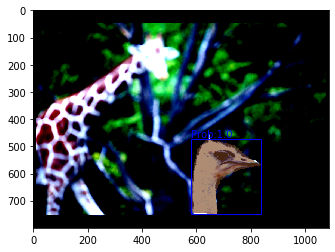

torch.Size([1, 3, 800, 1088])


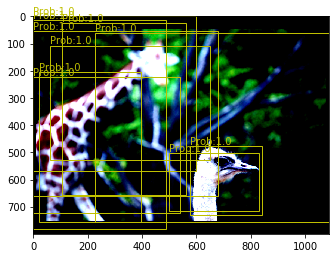

In [171]:
def plot_rpn_proposals(fpn_network, rpn_network, scaled_image, modified_label_list, limit):

  rpn_network.eval()
  fpn_network.eval()

  Utilities.plot_image(np.clip(scaled_image, 0, 1), modified_label_list)
  inp_tensor = torch.tensor(scaled_image).type(torch.float).to(device)
  E = inp_tensor.unsqueeze(0)
  print(E.shape)
  backout = fpn_network(E)
  im_lis = ImageList(E, [(800,1088)])
  rpnout = rpn_network(im_lis,backout)
  image_boxes_orig = rpnout[0][0]
  image_boxes = image_boxes_orig.cpu().numpy()
  proposal_labels = []
  for i in range(image_boxes.shape[0]):
    x1,y1,x2,y2 = list(image_boxes[i,:])
    bbox = BBox((x1,y1),(x2,y2))
    asp = bbox.w * 1.0 / bbox.h
    proposal_labels.append(Label(bbox, 0, None))
  Utilities.plot_image(np.clip(scaled_image, 0, 1), proposal_labels[:limit])

scaled_image, modified_label_list  = sfl.get_obj_item(3022)
plot_rpn_proposals(backbone, rpn, scaled_image, modified_label_list, 10)

## Test Label assignment

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


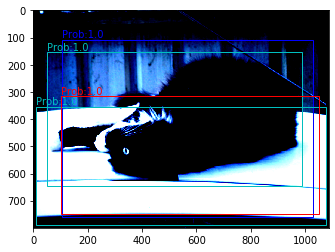

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


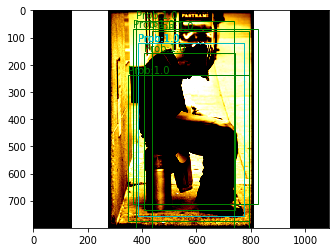

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


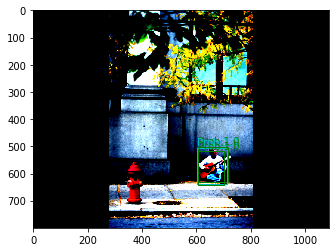

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


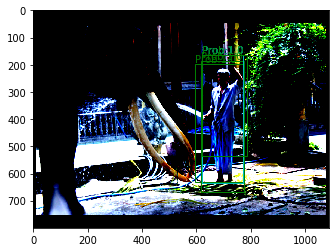

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


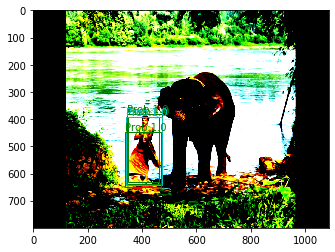

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


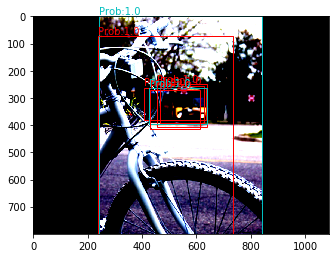

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


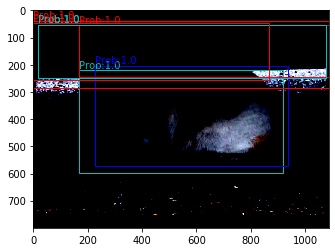

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


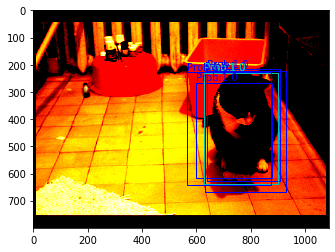

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


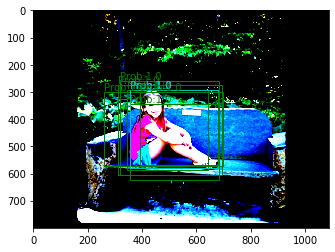

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


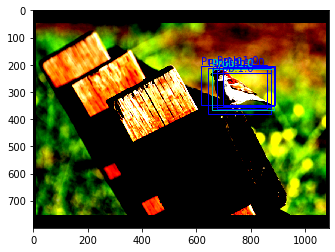

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


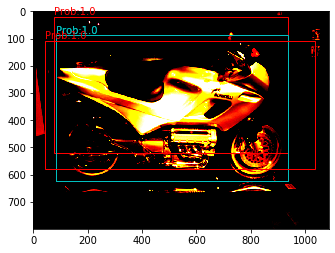

In [14]:
## Plot assigned labels

c = 0

for image, boxes, masks, labels, _, _ in test_data_loader:
  image = image[0, :, :, :]
  boxes = boxes[0]
  masks = masks[0]
  labels = labels[0]

  inp_tensor = torch.tensor(image).type(torch.float).to(device)
  E = inp_tensor.unsqueeze(0)
  backout = backbone(E)
  im_lis = ImageList(E, [(800,1088)])
  rpnout = rpn(im_lis,backout)
  image_boxes_orig = rpnout[0][0]

  r_wise_boxes, r_wise_labels, r_wise_box_allocation = assign_boxes_to_labels(boxes.to(device), image_boxes_orig, labels.type(torch.float).to(device))


  proposal_labels = []
  for i in range(1000):
    x1,y1,x2,y2 = list(image_boxes_orig[i, :].cpu().numpy())
    bbox = BBox((x1,y1),(x2,y2))
    asp = bbox.w * 1.0 / bbox.h
    if r_wise_labels[i].cpu().item() > 0:
      x1,y1,x2,y2 = list(r_wise_boxes[i].cpu().numpy())
      btemp = BBox((x1,y1),(x2,y2))
      proposal_labels.append(Label(btemp, -1, None))
      proposal_labels.append(Label(bbox, r_wise_labels[i].item(), None))
          

  Utilities.plot_image(image.numpy(), proposal_labels[:50])

  c += 1
  if c > 10:
    break




# ROI Align

In [0]:
# points is a 1000x4 size
import torch
import random
import itertools

# numpy input all 
# feature_map: 256xHxW
def bilinear_interpolate(feature_map, x_points, y_points):
  
  r,c = feature_map.shape[1:3]
  x_1, y_1 = torch.floor(x_points).type(torch.long).to(device), torch.floor(y_points).type(torch.long).to(device)
  x_2, y_2 = x_1 + 1, y_1 + 1

  x_1, y_1 = torch.clamp(x_1, 0, c-1), torch.clamp(y_1, 0, r-1)
  x_2, y_2 = torch.clamp(x_2, 0, c-1), torch.clamp(y_2, 0, r-1)

  p,q,r,s = feature_map[:, y_1, x_1], feature_map[:, y_2, x_1], feature_map[:, y_1, x_2], feature_map[:, y_2, x_2] 

  x_1, x_2 = x_1.type(torch.float), x_2.type(torch.float)
  y_1, y_2 = y_1.type(torch.float), y_2.type(torch.float)

  wp, wq = (x_2 - x_points) * (y_2 - y_points), (x_2 - x_points) * (y_points - y_1)
  wr, ws = (x_points - x_1) * (y_2 - y_points), (x_points - x_1) * (y_points - y_1)

  inter_ans = wp*p + wq*q + wr*r + ws*s

  return inter_ans


def vec_roi_allocation(points):
  pooler_scales = torch.tensor([0.25, 0.125, 0.0625, 0.03125])
  l_min = -torch.log2(pooler_scales[0])
  l_max = -torch.log2(pooler_scales[-1])

  area = (points[:,2] - points[:,0]) * (points[:,3] - points[:,1])
  area_root = torch.sqrt(area)
  l_val = torch.floor(5 + torch.log2(area_root/933.0))
  l_val = torch.clamp(l_val, 2, 5).type(torch.long)
  scales = pooler_scales[l_val-2]
  return l_val, scales

def random_distance(interval_size, fraction, count, prob=False):
  if not prob:
    frac = [fraction for i in range(count)]
  else:
    frac = [round(random.uniform(0.001, 0.999), 3) for i in range(count)]
  
  return torch.tensor(frac) * interval_size


def roi_align(Pimage, box_points, scale, f_size, sample_size):

  C = Pimage.shape[0]

  box_points = [i*scale for i in box_points]
  x1,y1,x2,y2 = box_points

  x_interval_size = (x2 - x1)/(f_size[1]) 
  y_interval_size = (y2 - y1)/(f_size[0])

  points_x = x1 + np.arange(0,f_size[1]+1)*x_interval_size
  points_y = y1 + np.arange(0,f_size[0]+1)*y_interval_size

  xv, yv = np.meshgrid(points_x[:-1], points_y[:-1])

  x_left = torch.tensor(xv.reshape(-1)).to(device)
  y_left = torch.tensor(yv.reshape(-1)).to(device)

  frac_list_x = [(i + 0.5) * x_interval_size/sample_size for i in range(sample_size)]
  frac_list_y = [(i + 0.5) * y_interval_size/sample_size for i in range(sample_size)]

  x_cords = []
  y_cords = []

  for x_frac, y_frac in list(itertools.product(frac_list_x, frac_list_y)):

    x_new = x_left + x_frac
    y_new = y_left + y_frac 

    x_cords += list(x_new)
    y_cords += list(y_new)
  
  output = bilinear_interpolate(Pimage, torch.tensor(x_cords, dtype=torch.float, device=device), torch.tensor(y_cords, dtype=torch.float, device=device))

  output = output.reshape(C, len(frac_list_x)*len(frac_list_y), f_size[0], f_size[1])
  output = output.permute(0, 2, 3, 1)

  roi_vec = torch.mean(output, dim=3)

  return roi_vec



## ROI Align Vectorized

In [0]:
def roi_align_group(Pimage, box_points, scale, f_size, sample_size):

  C = Pimage.shape[0]

  box_points = scale * box_points
  x1, x2 = box_points[:,0], box_points[:,2]
  y1, y2 = box_points[:,1], box_points[:,3]

  plen = box_points.shape[0]

  x_interval_size = (x2 - x1)/(f_size[1]) 
  y_interval_size = (y2 - y1)/(f_size[0])

  points_x = x1.reshape((-1, 1)).repeat(1,f_size[1]+1) + torch.arange(0,f_size[1]+1).to(device).repeat(plen, 1)*x_interval_size.reshape((-1, 1)).repeat(1,f_size[1]+1)
  points_y = y1.reshape((-1, 1)).repeat(1,f_size[0]+1) + torch.arange(0,f_size[0]+1).to(device).repeat(plen, 1)*y_interval_size.reshape((-1, 1)).repeat(1,f_size[0]+1)

  y_len = points_y.shape[0]
  xv, yv = points_x[:,:-1].repeat(1, f_size[0]), points_y[:,:-1].reshape(-1).repeat(f_size[1], 1).transpose(0,1).reshape(y_len, -1)

  x_left = xv.reshape(-1).to(device)
  y_left = yv.reshape(-1).to(device)

  frac_list_x = [(i + 0.5)/sample_size  for i in range(sample_size)]
  frac_list_y = [(i + 0.5)/sample_size  for i in range(sample_size)]

  x_cords = torch.zeros(int(x_interval_size.shape[0])*  f_size[0]*f_size[1] * len(frac_list_x) * len(frac_list_x), dtype=torch.float, device=device)
  y_cords = torch.zeros(int(y_interval_size.shape[0])*  f_size[0]*f_size[1] * len(frac_list_x) * len(frac_list_x), dtype=torch.float, device=device)

  pending = 0
  for x_frac, y_frac in list(itertools.product(frac_list_x, frac_list_y)):

    x_flat = (x_interval_size.reshape(-1, 1).repeat(1, f_size[0]*f_size[1])* x_frac).reshape(-1)
    y_flat = (y_interval_size.reshape(-1, 1).repeat(1, f_size[0]*f_size[1])* y_frac).reshape(-1)

    x_new = x_left + x_flat
    y_new = y_left + y_flat

    c = x_new.shape[0]

    x_cords[pending:pending+c] = x_new
    y_cords[pending:pending+c] = y_new

    pending = pending + c
  
  output = bilinear_interpolate(Pimage, x_cords, y_cords)

  output = output.reshape(C, len(frac_list_x)*len(frac_list_y), plen, f_size[0], f_size[1])
  output = output.permute(0, 2, 3, 4, 1)
  roi_vec = torch.mean(output, dim=4)

  del output, x_cords, y_cords, x_left, y_left, xv, yv, x1, x2, y1, y2, x_interval_size, y_interval_size

  return roi_vec


## Plot ROI Align

FPN Time :  0.28467464447021484
Vec alloc time :  0.0008389949798583984
Roi Time : 0.019330263137817383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


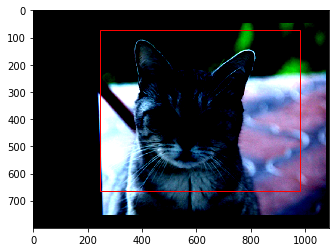

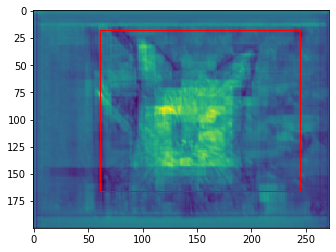

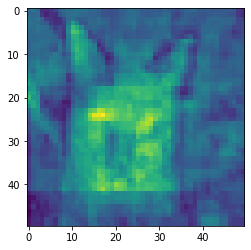

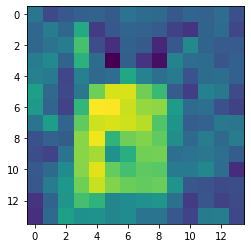

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


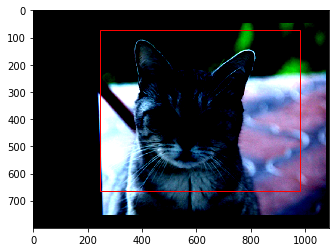

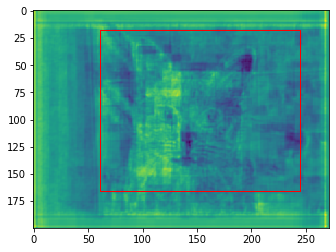

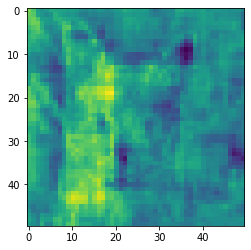

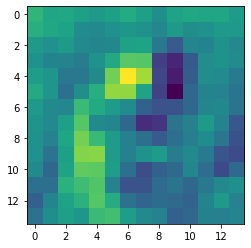

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


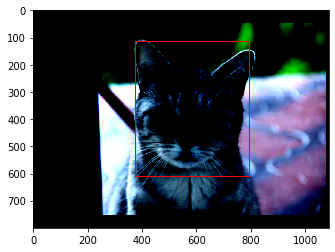

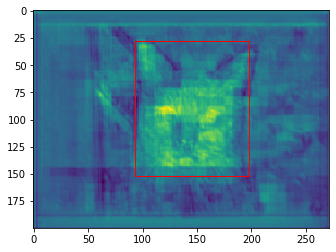

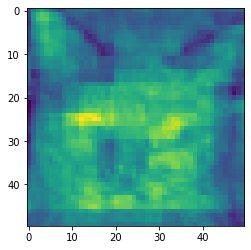

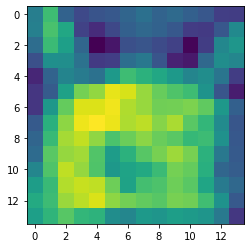

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


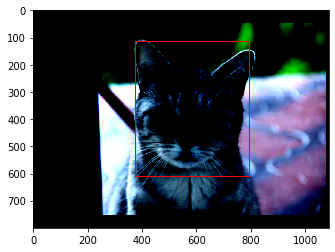

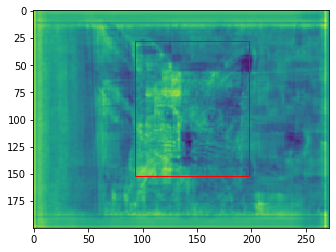

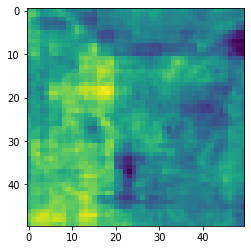

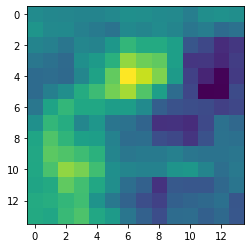

In [17]:
def plot_roi_align(fpn_network, rpn_network, scaled_image, modified_label_list, box_num, f_num_lim):

  fpn_network.eval()
  rpn_network.eval()
  import time
  st = time.time()
  inp_tensor = torch.tensor(scaled_image).type(torch.float).to(device)
  E = inp_tensor.unsqueeze(0)
  backout = fpn_network(E)
  im_lis = ImageList(E, [(800,1088)])
  rpnout = rpn_network(im_lis,backout)
  e_fr = time.time()
  image_boxes_orig = rpnout[0][0]
  l_v, scales = vec_roi_allocation(image_boxes_orig)

  e_vec_alloc = time.time()

  roi_group_output = roi_align_group(backout[0][0, :, :, :] , image_boxes_orig[0:2, :], 0.25, [50, 50], 2)
  roi_group_cmp_output = roi_align_group(backout[1][0, :, :, :] , image_boxes_orig, 0.125, [14, 14], 2)

  e_roi = time.time()

  print("FPN Time : ", e_fr - st)
  print("Vec alloc time : ", e_vec_alloc - e_fr)
  print("Roi Time :", e_roi -  e_vec_alloc)

  for i in range(2):
    for f_num in range(f_num_lim):
      points = image_boxes_orig[i, :]
      px = points * 0.25
      patch = backout[0][0, :, :, :]
      x_size, y_size = int(px[2] - px[0]), int(px[3] - px[1])

      ax = plt.gca()
      rect = patches.Rectangle((px[0]*4, px[1]*4), x_size*4, y_size*4, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.imshow(np.moveaxis(scaled_image, 0, -1))
      plt.show()
      
      ax = plt.gca()
      rect = patches.Rectangle((px[0], px[1]), x_size, y_size, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.imshow(patch[f_num, :, :].detach().cpu().numpy())
      plt.show()

      plt.imshow(roi_group_output[f_num, i, :, :].detach().cpu().numpy())
      plt.show()

      plt.imshow(roi_group_cmp_output[f_num, i, :, :].detach().cpu().numpy())
      plt.show()



scaled_image, modified_label_list  = sfl.get_obj_item(6)
plot_roi_align(backbone, rpn, scaled_image, modified_label_list, 0, 2)

# Model Definition

Define the four models

In [0]:
class ROIAlign(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, fpn_out, rpn_out, p_size):
    blen = int(fpn_out[0].shape[0])
    box_count = rpn_out[0][0].shape[0]
    feature_output = torch.zeros((blen, box_count, FP_C, p_size[0], p_size[1]), dtype=torch.float, device=device)
    scale_output = torch.zeros((blen, box_count), dtype=torch.float, device=device)
    m = torch.nn.ReplicationPad2d([0,1,0,1])
    for sample_index in range(blen):
      image_boxes_orig = rpn_out[0][sample_index]
      l_v, scales = vec_roi_allocation(image_boxes_orig)
      # reset computed scales to 2
      l_v[:] = 2
      scales[:] = 0.25

      for level_value in [2,3,4,5]:
        current_level_indexes = (l_v.cpu()== level_value).nonzero()
        if current_level_indexes.shape[0] == 0:
          continue
        patch = fpn_out[level_value - 2][sample_index, :, :, :]
        patch = m(patch.unsqueeze(0)).squeeze(0)
        current_level_indexes = current_level_indexes.reshape(-1)
        scale_value = float(scales[current_level_indexes[0]].cpu())
        current_boxes = image_boxes_orig[current_level_indexes, :]
        roi_vec = roi_align_group(patch, current_boxes, scale_value, p_size, 2)
        feature_output[sample_index, current_level_indexes, :, :, :] = roi_vec.permute(1,0,2,3)
        scale_output[sample_index, current_level_indexes] = scale_value  
    return feature_output, scale_output


class InterNetwork(torch.nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    layer1 = torch.nn.Linear(input_dim, 1024)
    layer2 = torch.nn.Linear(1024, 1024)
    self.network = torch.nn.Sequential(layer1, torch.nn.ReLU(), layer2, torch.nn.ReLU())
  
  def forward(self, X):
    return self.network.forward(X)
  

class Classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    layer1 = torch.nn.Linear(1024, PRED_CLASSES)
    self.network = torch.nn.Sequential(layer1, torch.nn.LogSoftmax())
    
  def forward(self, X):
    return self.network.forward(X)

class Regressor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.network = torch.nn.Linear(1024, PRED_CLASSES*4)    
  def forward(self, X):
    return self.network.forward(X)

class Masks(torch.nn.Module):
  def __init__(self):
    super().__init__()
    conv1 = torch.nn.Conv2d(256, 256, 3, padding=1)
    conv2 = torch.nn.Conv2d(256, 256, 3, padding=1)
    conv3 = torch.nn.Conv2d(256, 256, 3, padding=1)
    conv4 = torch.nn.Conv2d(256, 256, 3, padding=1)
    conv5 = torch.nn.ConvTranspose2d(256, 256, 2, stride=2, padding=1)
    conv6 = torch.nn.Conv2d(256, PRED_CLASSES, 1, padding=1)
    self.network = torch.nn.Sequential(conv1, torch.nn.ReLU(), conv2, torch.nn.ReLU(), conv3, torch.nn.ReLU(), conv4, torch.nn.ReLU(), conv5, conv6, torch.nn.Sigmoid())
    
  def forward(self, X):
    return self.network.forward(X)

# Network Wrapper

In [0]:
import time
import torch.nn.functional as F
import torch.optim as optim

class NetworkWrapper():
  def __init__(self, backbone, rpn, roi, inter, classifier, regressor, load_from=None):
    self.fpn_network, self.rpn_network = backbone, rpn
    self.roi_network = roi 
    self.classifier_network = classifier.to(device)
    self.regressor_network = regressor.to(device)
    self.inter_network = inter.to(device)
    self.lr = 0.0001
    #self.regression_optimizer = optim.Adam(list(self.inter_network.parameters()) + list(self.regressor_network.parameters()) , lr=self.l_r)
    #self.classification_optimizer = optim.Adam(list(self.inter_network.parameters()) + list(self.classifier_network.parameters()) , lr=self.l_r)
    self.total_optimizer = optim.Adam(list(self.inter_network.parameters()) + list(self.regressor_network.parameters()) + list(self.classifier_network.parameters()) , lr=self.lr)
    self.train_loss_data = []
    self.test_loss_data = []
    
    self.fpn_network.eval()
    self.rpn_network.eval()

    self.rpn_cache = {}

    if load_from is not None:
      self.load_model(load_from)
  
  def save_network(self, PATH):
    save_dict = {}
    save_dict['classifier_network_dict'] = self.classifier_network.state_dict()
    save_dict['regressor_network_dict'] = self.regressor_network.state_dict()
    save_dict['inter_network_dict'] = self.inter_network.state_dict()
    save_dict['total_optimizer_dict'] = self.total_optimizer.state_dict()
    save_dict['train_loss_data'] = self.train_loss_data
    save_dict['test_loss_data'] = self.test_loss_data
    torch.save(save_dict, PATH)
  
  def load_model(self, PATH):
    checkpoint = torch.load(PATH)
    self.classifier_network.load_state_dict(checkpoint['classifier_network_dict'])
    self.regressor_network.load_state_dict(checkpoint['regressor_network_dict'])
    self.inter_network.load_state_dict(checkpoint['inter_network_dict'])
    
    self.total_optimizer.load_state_dict(checkpoint['total_optimizer_dict'])
    self.train_loss_data = checkpoint['train_loss_data']
    self.test_loss_data = checkpoint['test_loss_data']


  def get_fpn_output(self, inp_tensor):
    fpn_out = self.fpn_network(inp_tensor)
    return fpn_out
  
  def get_rpn_out(self, inp_tensor, fpn_out, orig_index=None):
    blen = int(inp_tensor.shape[0])
    im_lis = ImageList(inp_tensor, [(800,1088) for i in range(blen)])
    rpnout = self.rpn_network(im_lis, fpn_out) 
    return rpnout
  
  def get_roi_align(self, fpn_out, rpn_out, p_size):
    return self.roi_network.forward(fpn_out, rpn_out, p_size)
  
  def get_inter_output(self, inter_input):
    inter_output = self.inter_network.forward(inter_input)
    return inter_output
  
  def get_classifier_output(self, inter_output):
    return self.classifier_network.forward(inter_output)
  
  def get_regression_output(self, inter_output):
    return self.regressor_network.forward(inter_output)
  
  # 1:1 sampling
  def sample_classification(self, assigned_labels):
    positive_indexes = (assigned_labels > 0).nonzero().reshape(-1)
    background_indexes =  (assigned_labels == 0).nonzero().reshape(-1)
    if positive_indexes.shape[0] > background_indexes.shape[0]:
      return torch.cat((positive_indexes, background_indexes), 0)
    
    full_list = np.arange(background_indexes.shape[0])
    np.random.shuffle(full_list)
    required_list = full_list[:positive_indexes.shape[0]]
    return torch.cat((positive_indexes, background_indexes[required_list]), 0)
  
  def regression_indexes(self, assigned_labels):
    positive_indexes = (assigned_labels > 0).nonzero().reshape(-1)
    return positive_indexes
  
  def cls_regression(self, class_output, box_assigned_label):
    box_assigned_label = box_assigned_label.reshape(-1).type(torch.long)
    loss_value = F.nll_loss(class_output, box_assigned_label, reduction="sum")
    return loss_value, class_output.shape[0]
  
  def loss_regression(self, reg_feature_vector, reg_output, box_assigned_label):
    # flat it
    reg_feature_vector = reg_feature_vector.reshape(-1, 4)
    box_assigned_label = box_assigned_label.reshape(-1).type(torch.long)
    reg_output = reg_output.reshape(-1, 4, 4)
    reg_output_for_true_class = reg_output[torch.arange(reg_feature_vector.shape[0]), box_assigned_label, :]
    indexes = self.regression_indexes(box_assigned_label)
    sample_reg_output_for_true_class = reg_output_for_true_class[indexes, :]
    sample_ground_truth = reg_feature_vector[indexes, :]
    loss_value = F.smooth_l1_loss(sample_reg_output_for_true_class, sample_ground_truth, reduction="sum")
    return loss_value, sample_reg_output_for_true_class.shape[0]
  
  
  def exec_input(self, inp_tensor, boxes, labels, fpn_out, rpn_out, sampling=True, orig_index=None):
    
    blen = int(inp_tensor.shape[0])
    box_count = rpn_out[0][0].shape[0]

    reg_feature_vector = torch.zeros((blen, box_count, 4), dtype=torch.float, device=device)
    box_assigned_label = torch.zeros((blen, box_count), dtype=torch.float, device=device)

    total_sampled_boxes = 0

    sample_index_list = []  

    dummy_sample_list = [] 


    for sample_index in range(inp_tensor.shape[0]):
      r_wise_boxes, r_wise_labels,_ = assign_boxes_to_labels(boxes[sample_index].to(device), rpn_out[0][sample_index], labels[sample_index].type(torch.float).to(device), th=0.4)
      reg_fev = feature_transformation(rpn_out[0][sample_index], r_wise_boxes, r_wise_labels.type(torch.long), 3)

      reg_feature_vector[sample_index, :, :] = reg_fev
      box_assigned_label[sample_index, :] = r_wise_labels

      sampled_indexes = None
      
      s_i = self.sample_classification(r_wise_labels)
      dummy_sample_list.append(s_i)

      if sampling:
        sampled_indexes = s_i
      else:
        sampled_indexes = torch.arange(r_wise_labels.shape[0], dtype=torch.long, device=device)

      sample_index_list.append(sampled_indexes)

      total_sampled_boxes += sampled_indexes.shape[0]
    
    reg_feature_vector_flat = torch.zeros((total_sampled_boxes, 4), dtype=torch.float, device=device)
    box_assigned_label_flat = torch.zeros((total_sampled_boxes), dtype=torch.float, device=device)
    inter_input_flat = torch.zeros((total_sampled_boxes, FP_C*P_SIZE_RC[0]*P_SIZE_RC[1]), dtype=torch.float, device=device)
    pending = 0
    for sample_index in range(inp_tensor.shape[0]):
      fpn_temp = []
      rpn_temp = [[rpn_out[0][sample_index][sample_index_list[sample_index], :]], None]
      for p_index in range(len(fpn_out)-1):
        pyramid = fpn_out[p_index]
        shrinked_pyramid = pyramid[sample_index:sample_index+1, :, :, :]
        fpn_temp.append(shrinked_pyramid)
      
      current_size = sample_index_list[sample_index].shape[0]

      reg_feature_vector_flat[pending: pending+current_size, :] =  reg_feature_vector[torch.ones(current_size, dtype=torch.long)*sample_index, sample_index_list[sample_index], :]
      box_assigned_label_flat[pending:pending+current_size] = box_assigned_label[torch.ones(current_size, dtype=torch.long)*sample_index, sample_index_list[sample_index]]
      
      
      roi_output, scale_output = self.get_roi_align(fpn_temp, rpn_temp, P_SIZE_RC)
      bsize, N = roi_output.shape[0], roi_output.shape[1] 
      inter_input = roi_output.reshape(bsize*N , -1)

      inter_input_flat[pending:pending+current_size, :] = inter_input
      pending += current_size
    

    inter_output = self.get_inter_output(inter_input_flat)
    class_output = self.get_classifier_output(inter_output)
    reg_output = self.get_regression_output(inter_output)

    return reg_feature_vector, box_assigned_label, dummy_sample_list, reg_feature_vector_flat, box_assigned_label_flat, reg_output, class_output
  
def train_regression_classification(nw, train_data_loader, epoch_num=0):
  total_loss = 0 
  reg_loss = 0
  cls_loss = 0
  c = 0
  for image, boxes, masks, labels, index, o_index in train_data_loader:
    o_index = [int(i) for i in o_index]
    inp_tensor = image.to(device).type(torch.float)
    fpn_out = nw.get_fpn_output(inp_tensor)
    rpn_out = nw.get_rpn_out(inp_tensor, fpn_out, orig_index=o_index)

    reg_feature_vector, box_assigned_label, sample_index_list, reg_feature_vector_flat, box_assigned_label_flat, reg_output, class_output = nw.exec_input(inp_tensor, boxes, labels, fpn_out, rpn_out, sampling=True, orig_index=o_index)
    reg_loss_value, reg_div_factor = nw.loss_regression(reg_feature_vector_flat, reg_output, box_assigned_label_flat)
    cls_loss_value, cls_div_factor = nw.cls_regression(class_output, box_assigned_label_flat)
    
    nw.total_optimizer.zero_grad()
    loss_value = 5 * reg_loss_value / reg_div_factor + cls_loss_value / cls_div_factor
    reg_loss += reg_loss_value.cpu().item() / reg_div_factor
    cls_loss += cls_loss_value.cpu().item() / cls_div_factor
    total_loss += loss_value.cpu().item()

    loss_value.backward()
    nw.total_optimizer.step()
    c += 1

  
  reg_average = reg_loss / c
  cls_average = cls_loss / c
  total_average = total_loss / c

  print("Train, Epoch : {}, Reg_avg:{}, Cls_average:{}, Total_average:{}".format(epoch_num, reg_average, cls_average, total_average))
  return (reg_average, cls_average, total_average)
  


def test_regression_classification(nw, data_loader, epoch_num=0):

  total_loss = 0 
  reg_loss = 0
  cls_loss = 0
  count = 0

  target = []
  pred = []
  from sklearn.metrics import classification_report

  with torch.no_grad():
    for image, boxes, masks, labels, index, o_index in data_loader:
      o_index = [int(i) for i in o_index]
      inp_tensor = image.to(device).type(torch.float)
      fpn_out = nw.get_fpn_output(inp_tensor)
      rpn_out = nw.get_rpn_out(inp_tensor, fpn_out, orig_index=o_index)
      reg_feature_vector, box_assigned_label, sample_index_list, reg_feature_vector_flat, box_assigned_label_flat, reg_output, class_output = nw.exec_input(inp_tensor, boxes, labels, fpn_out, rpn_out, sampling=False, orig_index=o_index)
      conf_output, label_output = torch.max(class_output, dim=1)
      target += list(box_assigned_label_flat.detach().cpu().numpy())[:100]
      pred += list(label_output.detach().cpu().numpy())[:100]
      
      reg_loss_value, reg_div_factor = nw.loss_regression(reg_feature_vector_flat, reg_output, box_assigned_label_flat)
      cls_loss_value, cls_div_factor = nw.cls_regression(class_output, box_assigned_label_flat)
      loss_value = 5* reg_loss_value / reg_div_factor + cls_loss_value / cls_div_factor
      reg_loss += reg_loss_value.cpu().item() / reg_div_factor
      cls_loss += cls_loss_value.cpu().item() / cls_div_factor
      total_loss += loss_value.cpu().item()
      count += 1
  
  print(classification_report(pred, target))
  reg_average = reg_loss / count
  cls_average = cls_loss / count
  total_average = total_loss / count

  print("Test, Epoch : {}, Reg_avg:{}, Cls_average:{}, Total_average:{}".format(epoch_num, reg_average, cls_average, total_average))
  return (reg_average, cls_average, total_average)
    
roi = ROIAlign()
inter = InterNetwork(FP_C*P_SIZE_RC[0]*P_SIZE_RC[1])
classifier = Classifier()
regressor = Regressor()

nw = NetworkWrapper(backbone, rpn, roi, inter, classifier, regressor)

## Train Regressor and Classification network


In [159]:
nw = NetworkWrapper(backbone, rpn, roi, inter, classifier, regressor)

for e in range(100):
  train_loss_epoch = train_regression_classification(nw, train_data_loader, epoch_num=e)
  nw.train_loss_data.append(train_loss_epoch)
  test_loss_epoch = test_regression_classification(nw, test_data_loader, epoch_num=e)
  nw.test_loss_data.append(test_loss_epoch)
  nw.save_network('./gdrive/My Drive/CIS680_2019/HW3a/ex1_reg_class')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: ignored

# Mask

In [0]:
from skimage.transform import rescale, resize

## assuming constant scale
def mask_ground_truth(rpn_out, allocation, masks, scale, sample_size=2):
  output = torch.zeros((rpn_out.shape[0], P_SIZE_MA[0]*2, P_SIZE_MA[1]*2), dtype=torch.float, device=device)
  for mask_index_int in range(masks.shape[0]):
    mask_indexes = (allocation == mask_index_int).nonzero().reshape(-1)
    mask_boxes = rpn_out[mask_indexes, :]
    mask_allocations = allocation[mask_indexes]
    if mask_boxes.shape[0] > 0:
      align_output = roi_align_group(masks[mask_index_int, :, :].unsqueeze(0), mask_boxes, scale, [28, 28], sample_size)
      output[mask_indexes, :, :] = align_output.squeeze(0)
  return output


class Mask_Network_Wrapper(): 

  def __init__(self, mask_network, nw, load_from=None):
    self.lr = 0.0001
    self.nw = nw
    self.mask_network = mask_network.to(device)
    self.total_optimizer = optim.Adam(list(self.mask_network.parameters()) + list(self.nw.inter_network.parameters()) + list(self.nw.regressor_network.parameters()) + list(self.nw.classifier_network.parameters()) , lr=self.lr)
    # self.total_optimizer = optim.Adam(list(self.mask_network.parameters()) , lr=self.lr)
    self.train_loss_data = []
    self.test_loss_data = []
    if load_from is not None:
      self.load_network(load_from)
     
  def save_network(self, PATH):
    save_dict = {}
    save_dict['mask_network_dict'] = self.mask_network.state_dict()
    save_dict['total_optimizer_dict'] = self.total_optimizer.state_dict()
    save_dict['train_loss_data'] = self.train_loss_data
    save_dict['test_loss_data'] = self.test_loss_data

    save_dict['classifier_network_dict'] = self.nw.classifier_network.state_dict()
    save_dict['regressor_network_dict'] = self.nw.regressor_network.state_dict()
    save_dict['inter_network_dict'] = self.nw.inter_network.state_dict()



    torch.save(save_dict, PATH)
  
  def load_network(self, PATH):
    checkpoint = torch.load(PATH)
    self.mask_network.load_state_dict(checkpoint['mask_network_dict'])
    
    self.train_loss_data = checkpoint['train_loss_data']
    self.test_loss_data = checkpoint['test_loss_data']


    self.nw.classifier_network.load_state_dict(checkpoint['classifier_network_dict'])
    self.nw.regressor_network.load_state_dict(checkpoint['regressor_network_dict'])
    self.nw.inter_network.load_state_dict(checkpoint['inter_network_dict'])

    self.total_optimizer.load_state_dict(checkpoint['total_optimizer_dict'])

    for param_group in self.total_optimizer.param_groups:
      param_group['lr'] = 0.0001
  
  def simple_nms(self, boxes, prob, orig_indexes, overlapThresh):
    if boxes.shape[0] == 0:
      return torch.zeros((0, 4), dtype=torch.float, device=device), torch.zeros((0), dtype=torch.float, device=device), torch.zeros((0), dtype=torch.long, device=device) 
    
    sort_indexes = torch.argsort(prob, descending=True)
    working_boxes = boxes[sort_indexes, :]
    working_prob = prob[sort_indexes]
    working_indexes = orig_indexes[sort_indexes]

    ans = []
    ans_prob = []
    ans_index = []

    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    while working_boxes.shape[0] > 0:
      choosen_box = working_boxes[0, :]
      choosen_prob = working_prob[0]
      choosen_index = working_indexes[0]

      ans.append(choosen_box)
      ans_prob.append(choosen_prob)
      ans_index.append(choosen_index)

      working_boxes = working_boxes[1:,:]
      working_prob = working_prob[1:]
      working_indexes = working_indexes[1:]

      if(working_boxes.shape[0] == 0):
        break
      
      ious = IOU_Calculator_vec(choosen_box.repeat(working_boxes.shape[0],1), working_boxes)
      keep_indexes = (ious < overlapThresh).nonzero().reshape(-1)
      working_boxes = working_boxes[keep_indexes, :]
      working_prob = working_prob[keep_indexes]
      working_indexes = working_indexes[keep_indexes]
      
    return torch.stack(ans, dim=0), torch.tensor(ans_prob, device=device), torch.tensor(ans_index, device=device)

  
  def non_max_sup(self, next_level_boxes, next_level_labels, next_level_prob, next_level_indexes, th=0.5):

    output_box = []
    label_box = []
    prob_box = []
    output_indexes = []
    for label in [1,2,3]:
      test_label_spec_indexes = (next_level_labels == label).nonzero().reshape(-1)
      test_label_spec_boxes = next_level_boxes[test_label_spec_indexes, :]
      test_label_spec_prob = next_level_prob[test_label_spec_indexes]
      test_label_spec_oi = next_level_indexes[test_label_spec_indexes]      
      label_wise_output, label_wise_prob, label_wise_oi = self.simple_nms(test_label_spec_boxes, test_label_spec_prob, test_label_spec_oi, th)
      output_box.append(label_wise_output)
      prob_box.append(label_wise_prob)
      output_indexes.append(label_wise_oi)
      label_box.append(torch.ones(label_wise_output.shape[0], dtype=torch.long, device=device)*label)

    
    a,b,c,d = torch.cat(output_box, dim=0), torch.cat(label_box, dim=0), torch.cat(prob_box, dim=0), torch.cat(output_indexes, dim=0)
    
    return torch.cat(output_box, dim=0), torch.cat(label_box, dim=0), torch.cat(prob_box, dim=0), torch.cat(output_indexes, dim=0)
  
  # nms_boxes, nms_labels, nms_indexes, boxes, labels
  def nms_to_gt_index(self, next_level_boxes, next_level_labels, next_level_indexes,  boxes, labels, th=0.5):

    box_output = []
    index_output = []
    labels_output = []
    orig_index_output = []

    for label in [1,2,3]:
      bbox_indexes = (labels == label).nonzero().reshape(-1)
      current_boxes = boxes[bbox_indexes, :]
      current_labels =  labels[bbox_indexes]

      nl_box_indexes = (next_level_labels == label).nonzero().reshape(-1)
      nl_boxes = next_level_boxes[nl_box_indexes, :]
      nl_indexes = next_level_indexes[nl_box_indexes]

      if current_boxes.shape[0] == 0 or nl_box_indexes.shape[0] == 0:
        continue

      r_wise_boxes, r_wise_labels, r_wise_box_allocation = assign_boxes_to_labels(current_boxes, nl_boxes, current_labels, th=0.5)

      valid_box_indexes = (r_wise_labels > 0).nonzero().reshape(-1)

      box_output.append(nl_boxes[valid_box_indexes, :])
      index_output.append(r_wise_box_allocation[valid_box_indexes])
      labels_output.append(r_wise_labels[valid_box_indexes])
      orig_index_output.append(nl_indexes[valid_box_indexes])
    
    if(len(box_output) == 0):
      return torch.zeros((0,4), type=torch.float, device=device), torch.zeros((0), type=torch.float, device=device), torch.zeros((0), type=torch.float, device=device), torch.zeros((0), type=torch.float, device=device) 
    
    return torch.cat(box_output, dim=0), torch.cat(labels_output, dim=0), torch.cat(index_output, dim=0), torch.cat(orig_index_output, dim=0)


  # nms_boxes, nms_labels, nms_indexes, boxes, labels
  def nms_to_gt_2(self, next_level_boxes, next_level_labels, next_level_indexes,  boxes, labels, th=0.5):
    r_wise_boxes, r_wise_labels, r_wise_box_allocation = assign_boxes_to_labels(boxes, next_level_boxes, labels, th=0.5)
    valid_box_indexes = (r_wise_labels > 0).nonzero().reshape(-1)
    return next_level_boxes[valid_box_indexes, :], r_wise_labels[valid_box_indexes], r_wise_box_allocation[valid_box_indexes], next_level_indexes[valid_box_indexes]

  def reconstruct_labels(self, box_pred, reg_output):
    reconstruction = torch.zeros(box_pred.shape, dtype=torch.float, device=device)
    xp, yp = (box_pred[:,0] + box_pred[:,2])/2 , (box_pred[:,1] + box_pred[:,3])/2
    wp, hp = box_pred[:,2] - box_pred[:,0], box_pred[:,3] - box_pred[:,1]

    xg = xp + wp * reg_output[:, 0]
    yg = yp + hp * reg_output[:, 1]
    wg = wp * torch.exp(reg_output[:, 2])
    hg = hp * torch.exp(reg_output[:, 3])

    reconstruction[:,0], reconstruction[:,2] = torch.clamp(xg - wg/2, min=0, max=1087), torch.clamp(xg + wg/2, min=0, max=1087)
    reconstruction[:,1], reconstruction[:,3] = torch.clamp(yg - hg/2, min=0, max=799), torch.clamp(yg + hg/2, min=0, max=799)

    return reconstruction
  
  def infer_mask(self, nw, data_loader, epoch_num=0, plot=False):

    total_loss = 0
    reg_loss = 0
    cls_loss = 0
    mask_loss = 0
    div_fac = 0

    c = 0

    for image, boxes, masks, labels, index, o_index in data_loader:
      c += 1
      o_index = [int(i) for i in o_index]
      inp_tensor = image.to(device).type(torch.float)

      fpn_out = self.nw.get_fpn_output(inp_tensor)
      rpn_out = self.nw.get_rpn_out(inp_tensor, fpn_out, orig_index=o_index)

      reg_feature_vector, box_assigned_label, sample_index_list, reg_feature_vector_flat, box_assigned_label_flat, regg_output, class_output = self.nw.exec_input(inp_tensor, boxes, labels, fpn_out, rpn_out, sampling=False, orig_index=o_index)
      conf_output, label_output = torch.max(class_output, dim=1)
      reg_output = regg_output.reshape(-1, 4, 4)[torch.arange(class_output.shape[0]), label_output.type(torch.long), :]
      
      box_predicted = self.reconstruct_labels(rpn_out[0][0], reg_output)
      conf_output = torch.exp(conf_output)
      box_index_map = torch.arange(class_output.shape[0], device=device)
      valid_box_index = (conf_output > 0.5).nonzero().reshape(-1)

      if valid_box_index.shape[0] > 0 :
        next_level_boxes, next_level_labels, next_level_prob, next_level_indexes = box_predicted[valid_box_index, :], label_output[valid_box_index], conf_output[valid_box_index], box_index_map[valid_box_index]        

        boxes_d = boxes[0].to(device)
        label_d = labels[0].to(device)
        
        nms_boxes, nms_labels, nms_prob, nms_indexes = self.non_max_sup(next_level_boxes, next_level_labels, next_level_prob, next_level_indexes, th=0.5)
        
        sort_indexes = torch.argsort(nms_indexes)      
        nms_boxes, nms_labels, nms_prob, nms_indexes   = nms_boxes[sort_indexes, :], nms_labels[sort_indexes], nms_prob[sort_indexes], nms_indexes[sort_indexes]
        limit = 100 
        nms_boxes, nms_labels, nms_prob, nms_indexes  = nms_boxes[:100, :], nms_labels[:100], nms_prob[:100], nms_indexes[:100]
                
        # index_o is the index of the associated gt box.
        box_o, label_o, index_o, p_index = self.nms_to_gt_2(nms_boxes, nms_labels, nms_indexes, boxes_d, label_d, th=0.5)
        expected_mask_output = mask_ground_truth(box_predicted[p_index, :], index_o, masks[0].to(device), 1.0, sample_size=8)
        roi_output, _ = nw.get_roi_align(fpn_out, [[box_predicted[p_index, :]]], P_SIZE_MA)
        newtwork_input = roi_output.squeeze(0)
        network_output = self.mask_network.forward(newtwork_input)

        vis = network_output[torch.arange(expected_mask_output.shape[0]), label_o.type(torch.long), :, :]

        ########## PLOT Code

        if plot:
          print(nms_indexes)
          roi_output_2, _ = nw.get_roi_align(fpn_out, [[box_predicted[nms_indexes, :]]], P_SIZE_MA)
          newtwork_input_2 = roi_output_2.squeeze(0)
          network_output_2 = self.mask_network.forward(newtwork_input_2)
          vis_2 = network_output_2[torch.arange(nms_labels.shape[0]), nms_labels.type(torch.long), :, :]
          x_label_out = []
          for j in range(min(nms_indexes.shape[0], 40)):
            x1, y1, x2, y2 = box_predicted[nms_indexes[j], :].detach().cpu().numpy().astype(int)
            bbox = BBox([x1, y1], [x2, y2])
            big_mask = np.zeros((800, 1088), dtype=float)
            temp = vis_2[j, :, :].detach().cpu().numpy()
            temp = temp[2:-2, 2:-2]
            # plt.imshow(temp)
            # plt.show()
            # plt.imshow(expected_mask_output[j, :, :].detach().cpu().numpy())
            # plt.show()
            #temp = np.pad(temp, [(2, 2), (2, 2)], mode='constant')
            temp2 = resize(temp, (y2-y1, x2-x1))
            big_mask[y1:y2, x1:x2] = (temp2 > 0.9)
            prob = float(conf_output[nms_indexes[j]].detach().cpu())
            l_out = int(label_output[nms_indexes[j]].detach().cpu())
            label = Label(bbox, l_out, big_mask, prob=prob)
            x_label_out.append(label)
          
            _,_,_,_, complete_image = sfl.get_item_with_no_norm(int(o_index[0]))

            Utilities.plot_image(complete_image, [label])
          
          _,_,_,_, complete_image = sfl.get_item_with_no_norm(int(o_index[0]))
          _, gt_labels = sfl.get_obj_item(int(o_index[0]))
          Utilities.plot_image(complete_image, gt_labels)
          ## plot data
          # plt.imshow(image.squeeze(0).permute(1,2,0))
          # ax = plt.gca()
          # x1, y1, x2, y2 = box_predicted[p_index[0], :].detach().cpu().numpy()
          # rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='c', facecolor='none')
          # ax.add_patch(rect)
          # plt.show()
          # plt.imshow(expected_mask_output[0, :, :].detach().cpu().numpy())
          # plt.show()

          # plt.imshow(vis[0, :, :].detach().cpu().numpy())
          # plt.show()
        

        mask_loss_value = F.binary_cross_entropy(vis, (expected_mask_output >=0.5).type(torch.float), reduction='mean')
        mask_loss += mask_loss_value.item()
        div_fac += 1
        break
      
      reg_loss_value, reg_div_factor = nw.loss_regression(reg_feature_vector_flat, regg_output, box_assigned_label_flat)
      cls_loss_value, cls_div_factor = nw.cls_regression(class_output, box_assigned_label_flat)
      
    
    average_mask_loss = mask_loss * 1.0 /div_fac
    print("Test, Epoch : {}, Mask_Average:{}".format(epoch_num, average_mask_loss))
    return average_mask_loss
  

  def train_mask(self, nw, data_loader, epoch_num=0):
    total_loss = 0
    full_reg_loss = 0
    full_cls_loss = 0
    full_mask_loss = 0
    div_fac = 0

    c = 0
    
    inp_batch_reg = []
    inp_batch_cls = []
    inp_batch_mask = []

    out_batch_reg = []
    out_batch_cls = []
    out_batch_mask = []

    batch_mask_count = 0
    dt = time.time()
    for image, boxes, masks, labels, index, o_index in data_loader:
      c += 1
      #print(c)
      o_index = [int(i) for i in o_index]
      inp_tensor = image.to(device).type(torch.float)

      fpn_out = self.nw.get_fpn_output(inp_tensor)
      rpn_out = self.nw.get_rpn_out(inp_tensor, fpn_out, orig_index=o_index)

      # print('FPN and RPN', time.time() - dt)

      reg_feature_vector, box_assigned_label, sample_index_list, reg_feature_vector_flat, box_assigned_label_flat, regg_output, class_output = self.nw.exec_input(inp_tensor, boxes, labels, fpn_out, rpn_out, sampling=False, orig_index=o_index)
      conf_output, label_output = torch.max(class_output, dim=1)
      reg_output = regg_output.reshape(-1, 4, 4)[torch.arange(class_output.shape[0]), label_output.type(torch.long), :]
      
      box_predicted = self.reconstruct_labels(rpn_out[0][0], reg_output)
      conf_output = torch.exp(conf_output)
      box_index_map = torch.arange(class_output.shape[0], device=device)
      valid_box_index = (conf_output > 0).nonzero().reshape(-1)


      boxes_d = boxes[0].to(device)
      label_d = labels[0].to(device)

      box_predicted = boxes_d
      conf_output = torch.zeros(boxes_d.shape[0], device=device).type(torch.float) + 1.0
      box_index_map = torch.arange(boxes_d.shape[0], device=device)
      label_output = label_d
      valid_box_index = (conf_output > 0).nonzero().reshape(-1)


      if valid_box_index.shape[0] > 0 :

        #next_level_boxes, next_level_labels, next_level_prob, next_level_indexes = box_predicted[valid_box_index, :], label_output[valid_box_index], conf_output[valid_box_index], box_index_map[valid_box_index]

        next_level_boxes, next_level_labels, next_level_prob, next_level_indexes = box_predicted[valid_box_index, :], label_output[valid_box_index], conf_output[valid_box_index], box_index_map[valid_box_index]
        
        nms_boxes, nms_labels, nms_prob, nms_indexes = self.non_max_sup(next_level_boxes, next_level_labels, next_level_prob, next_level_indexes, th=0.5)
        
        sort_indexes = torch.argsort(nms_indexes)      
        nms_boxes, nms_labels, nms_prob, nms_indexes   = nms_boxes[sort_indexes, :], nms_labels[sort_indexes], nms_prob[sort_indexes], nms_indexes[sort_indexes]
        limit = 100 
        nms_boxes, nms_labels, nms_prob, nms_indexes  = nms_boxes[:100, :], nms_labels[:100], nms_prob[:100], nms_indexes[:100]

        if nms_boxes.shape[0] > 0:
          # index_o is the index of the associated gt box.
          box_o, label_o, index_o, p_index = self.nms_to_gt_2(nms_boxes, nms_labels, nms_indexes, boxes_d, label_d, th=0.5)
          expected_mask_output = mask_ground_truth(box_predicted[p_index, :], index_o, masks[0].to(device), 1.0, sample_size=8)
          roi_output, _ = nw.get_roi_align(fpn_out, [[box_predicted[p_index, :]]], P_SIZE_MA)
          newtwork_input = roi_output.squeeze(0)
          network_output = self.mask_network.forward(newtwork_input)

          batch_mask_count += network_output.shape[0]

          inp_batch_mask.append((expected_mask_output >=0.5).type(torch.float))
          out_batch_mask.append(network_output[torch.arange(expected_mask_output.shape[0]), label_o.type(torch.long), :, :])

          #print('Loop time', time.time() - dt)
          dt = time.time()
      
      inp_batch_reg.append(reg_feature_vector_flat[sample_index_list[0], :])
      out_batch_reg.append(regg_output[sample_index_list[0], :])
      inp_batch_cls.append(box_assigned_label_flat[sample_index_list[0]])
      out_batch_cls.append(class_output[sample_index_list[0]])
      
      if batch_mask_count > 5 or c == len(data_loader.dataset):
        reg_loss_value, reg_div_factor = nw.loss_regression(torch.cat(inp_batch_reg, dim=0), torch.cat(out_batch_reg, dim=0), torch.cat(inp_batch_cls, dim=0))
        cls_loss_value, cls_div_factor = nw.cls_regression(torch.cat(out_batch_cls, dim=0), torch.cat(inp_batch_cls, dim=0))
        
        mask_loss_value = F.binary_cross_entropy(torch.cat(out_batch_mask, dim=0), torch.cat(inp_batch_mask, dim=0), reduction='mean')
        reg_norm_value = reg_loss_value/reg_div_factor
        cls_norm_value = cls_loss_value/cls_div_factor
        
        total_loss_value = 2*mask_loss_value + 5*reg_norm_value + cls_norm_value

        full_mask_loss += mask_loss_value.item()
        full_reg_loss += reg_norm_value.item()
        full_cls_loss += cls_norm_value.item()
        total_loss += total_loss_value.item()
        
        
        self.total_optimizer.zero_grad()
        total_loss_value.backward()
        self.total_optimizer.step()

        div_fac += 1

        inp_batch_reg = []
        inp_batch_cls = []
        inp_batch_mask = []
        out_batch_reg = []
        out_batch_cls = []
        out_batch_mask = []
        batch_mask_count = 0
        
    average_mask_loss = full_mask_loss * 1.0 /div_fac
    average_reg_loss = full_reg_loss * 1.0 /div_fac
    average_cls_loss = full_cls_loss * 1.0 /div_fac
    average_total_loss = total_loss * 1.0 /div_fac

    print("Train, Epoch : {}, Reg_Average:{}, Cls_Average: {}, Mask_Average:{}, Total_Average:{}".format(epoch_num, average_reg_loss, average_cls_loss, average_mask_loss, average_total_loss))
    return (average_reg_loss, average_cls_loss, average_mask_loss, average_total_loss)

  
  def test_mask(self, nw, data_loader, epoch_num=0, plot=False):

    total_loss = 0
    full_reg_loss = 0
    full_cls_loss = 0
    full_mask_loss = 0
    div_fac = 0
    c = 0
    dt = time.time()
    for image, boxes, masks, labels, index, o_index in data_loader:
      c += 1
      #print(c)
      o_index = [int(i) for i in o_index]
      inp_tensor = image.to(device).type(torch.float)

      fpn_out = self.nw.get_fpn_output(inp_tensor)
      rpn_out = self.nw.get_rpn_out(inp_tensor, fpn_out, orig_index=o_index)

      # print('FPN and RPN', time.time() - dt)

      reg_feature_vector, box_assigned_label, sample_index_list, reg_feature_vector_flat, box_assigned_label_flat, regg_output, class_output = self.nw.exec_input(inp_tensor, boxes, labels, fpn_out, rpn_out, sampling=False, orig_index=o_index)
      conf_output, label_output = torch.max(class_output, dim=1)
      reg_output = regg_output.reshape(-1, 4, 4)[torch.arange(class_output.shape[0]), label_output.type(torch.long), :]
      
      box_predicted = self.reconstruct_labels(rpn_out[0][0], reg_output)
      conf_output = torch.exp(conf_output)
      box_index_map = torch.arange(class_output.shape[0], device=device)
      valid_box_index = (conf_output > 0).nonzero().reshape(-1)


      boxes_d = boxes[0].to(device)
      label_d = labels[0].to(device)


      ## uncomment it out and comment the next labels line to start training from a pre-trained regressor-classifier

      box_predicted = boxes_d
      conf_output = torch.zeros(boxes_d.shape[0], device=device).type(torch.float) + 1.0
      box_index_map = torch.arange(boxes_d.shape[0], device=device)
      label_output = label_d
      valid_box_index = (conf_output > 0).nonzero().reshape(-1)


      if valid_box_index.shape[0] > 0 :

        #next_level_boxes, next_level_labels, next_level_prob, next_level_indexes = box_predicted[valid_box_index, :], label_output[valid_box_index], conf_output[valid_box_index], box_index_map[valid_box_index]

        next_level_boxes, next_level_labels, next_level_prob, next_level_indexes = box_predicted[valid_box_index, :], label_output[valid_box_index], conf_output[valid_box_index], box_index_map[valid_box_index]
        
        nms_boxes, nms_labels, nms_prob, nms_indexes = self.non_max_sup(next_level_boxes, next_level_labels, next_level_prob, next_level_indexes, th=0.5)
        
        sort_indexes = torch.argsort(nms_indexes)      
        nms_boxes, nms_labels, nms_prob, nms_indexes   = nms_boxes[sort_indexes, :], nms_labels[sort_indexes], nms_prob[sort_indexes], nms_indexes[sort_indexes]
        limit = 100 
        nms_boxes, nms_labels, nms_prob, nms_indexes  = nms_boxes[:100, :], nms_labels[:100], nms_prob[:100], nms_indexes[:100]

        if nms_boxes.shape[0] > 0:
          # index_o is the index of the associated gt box.
          box_o, label_o, index_o, p_index = self.nms_to_gt_2(nms_boxes, nms_labels, nms_indexes, boxes_d, label_d, th=0.5)
          expected_mask_output = mask_ground_truth(box_predicted[p_index, :], index_o, masks[0].to(device), 1.0, sample_size=8)
          roi_output, _ = nw.get_roi_align(fpn_out, [[box_predicted[p_index, :]]], P_SIZE_MA)
          newtwork_input = roi_output.squeeze(0)
          network_output = self.mask_network.forward(newtwork_input)
          vis = network_output[torch.arange(expected_mask_output.shape[0]), label_o.type(torch.long), :, :]

          mask_loss_value = F.binary_cross_entropy(vis, (expected_mask_output >=0.5).type(torch.float), reduction='mean')
          reg_loss_value, reg_div_factor = nw.loss_regression(reg_feature_vector_flat, regg_output, box_assigned_label_flat)
          cls_loss_value, cls_div_factor = nw.cls_regression(class_output, box_assigned_label_flat)
          reg_norm_value = reg_loss_value/reg_div_factor
          cls_norm_value = cls_loss_value/cls_div_factor

          total_loss_value = 2*mask_loss_value + 5*reg_norm_value + cls_norm_value
          full_mask_loss += mask_loss_value.item()
          full_reg_loss += reg_norm_value.item()
          full_cls_loss += cls_norm_value.item()
          total_loss += total_loss_value.item()

          div_fac += 1

    average_mask_loss = full_mask_loss * 1.0 /div_fac
    average_reg_loss = full_reg_loss * 1.0 /div_fac
    average_cls_loss = full_cls_loss * 1.0 /div_fac
    average_total_loss = total_loss * 1.0 /div_fac

    print("Train, Epoch : {}, Reg_Average:{}, Cls_Average: {}, Mask_Average:{}, Total_Average:{}".format(epoch_num, average_reg_loss, average_cls_loss, average_mask_loss, average_total_loss))
    return (average_reg_loss, average_cls_loss, average_mask_loss, average_total_loss)
    

      

## Train Mask 

In [0]:

nw = NetworkWrapper(backbone, rpn, roi, inter, classifier, regressor)
m = Masks()
MNW = Mask_Network_Wrapper(m, nw)
for epoch in range(100):
  k = time.time()
  train_loss = MNW.train_mask(nw, train_data_loader, epoch_num=epoch)
  test_loss = MNW.test_mask(nw, test_data_loader, epoch_num=epoch)
  MNW.train_loss_data.append(train_loss)
  MNW.test_loss_data.append(test_loss)
  MNW.save_network('./gdrive/My Drive/CIS680_2019/HW3a/eye_full_mask')
  print('One Epoch Time :', epoch, time.time() - k)

## Test Mask

In [0]:
nw = NetworkWrapper(backbone, rpn, roi, inter, classifier, regressor, load_from='./gdrive/My Drive/CIS680_2019/HW3a/e4_reg5_cls1_0001')
m = Masks()
MNW = Mask_Network_Wrapper(m, nw, load_from='./gdrive/My Drive/CIS680_2019/HW3a/ex2_full_mask')
MNW.infer_mask(nw, test_data_loader, epoch_num=-1, plot=True)

## Plot Loss

In [0]:
def plot_data(train_error, test_error, title):
  epoch_number = [i+1 for i in range(len(train_error))]
  plt.title(title)
  plt.plot(epoch_number, train_error, label="train_loss")
  plt.plot(epoch_number, test_error, label="test_loss")
  plt.legend(loc='upper right')
  plt.show()

# Testing Regressor and Classifier

In [0]:
def test_recons(mk, data_loader):
    for image, boxes, masks, labels, _, oindexes in data_loader:
      inp_tensor = image.to(device).type(torch.float)
      fpn_out = nw.get_fpn_output(inp_tensor)
      rpn_out = nw.get_rpn_out(inp_tensor, fpn_out, orig_index=None)

      reg_feature_vector, box_assigned_label, sample_index_list, reg_feature_vector_flat, box_assigned_label_flat, regg_output, class_output = nw.exec_input(inp_tensor, boxes, labels, fpn_out, rpn_out, sampling=False, orig_index=None)
      
      conf_output, label_output = torch.max(class_output, dim=1)
      reg_output = regg_output.reshape(-1, 4, 4)[torch.arange(class_output.shape[0]), label_output.type(torch.long), :]
      box_predicted = mk.reconstruct_labels(rpn_out[0][0], reg_output)    
      conf_output = torch.exp(conf_output)
      box_index_map = torch.arange(class_output.shape[0], device=device)
      valid_box_index = (conf_output > 0.5).nonzero().reshape(-1)
      
      next_level_boxes = box_predicted[valid_box_index, :]
      next_level_labels = label_output[valid_box_index]
      next_level_prob = conf_output[valid_box_index]
      next_level_indexes = box_index_map[valid_box_index]

      nms_boxes, nms_labels, nms_prob, nms_indexes = mk.non_max_sup(next_level_boxes, next_level_labels, next_level_prob, next_level_indexes, th=0.5)

        
      sort_indexes = torch.argsort(nms_prob)
      nms_boxes = nms_boxes[sort_indexes, :]
      nms_labels = nms_labels[sort_indexes]
      nms_prob = nms_prob[sort_indexes]
      nms_indexes = nms_indexes[sort_indexes]

      print(nms_indexes)

      old_boxes =  rpn_out[0][0][nms_indexes, :]

      rec_labels = []
      for i in range(min(nms_boxes.shape[0], 2)):
        x1, y1, x2, y2 = nms_boxes[i,:].detach().cpu().numpy()
        box = BBox([x1,y1], [x2,y2])
        x1, y1, x2, y2 = old_boxes[i,:].detach().cpu().numpy()
        box2 = BBox([x1,y1], [x2,y2])
        
        label = Label(box, nms_labels[i].item(), None, 0)
        label2 = Label(box2, 0, None, nms_prob[i]) 
        if nms_labels[i].item() > 0 and nms_prob[i] > 0.5:
          rec_labels.append(label)
          #rec_labels.append(label2)


      orig_labels = []
      for i in range(boxes[0].shape[0]):
        x1, y1, x2, y2 = boxes[0][i,:].detach().cpu().numpy()
        box = BBox([x1,y1], [x2,y2])
        label = Label(box, int(labels[0][i]), None)
        orig_labels.append(label)
      
      rpn_labels = []
      for i in range(100):
        x1, y1, x2, y2 = rpn_out[0][0][i,:].detach().cpu().numpy()
        box = BBox([x1,y1], [x2,y2])

        x1,y1,x2,y2 = box_predicted[i, :].detach().cpu().numpy()
        box_pred = BBox([x1,y1], [x2,y2])

        label = Label(box, 0, None)
        label2 = Label(box_pred, -1, None)
        rpn_labels.append(label)
        rpn_labels.append(label2)
      
      _,_,_,_,no_norm_image = sfl.get_item_with_no_norm(int(oindexes[0]))

      Utilities.plot_image(no_norm_image, rec_labels)
      Utilities.plot_image(no_norm_image, orig_labels)
      Utilities.plot_image(no_norm_image, rpn_labels)      
      break

nw = NetworkWrapper(backbone, rpn, roi, inter, classifier, regressor, load_from='./gdrive/My Drive/CIS680_2019/HW3a/e4_reg5_cls1_0001')
m = Masks()
mk = Mask_Network_Wrapper(m, nw)
# kk = DataLoader(test_data_set, batch_size = 1, shuffle=False, collate_fn=custom_collate)
test_recons(mk, train_data_loader)